7 countries

6 page long policy briefs


USA
UK

EU (28)

India
France

1.1
USA
India
France

1.2
UK
USA (Hawaii? Alaska? -> check with country author)
EU(28) (Exclude oversees)
India
France

1.3
India


Excel spreadsheet

Columns -> countries
Rows -> years

Generate plots anyways

Generate maps


In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas
import affine
import fiona

from scipy import stats
from tqdm import tnrange, tqdm_notebook, tqdm


import weather_ecmwf
import population_tools

from config import (DATA_SRC, ERA_MONTHLY_FILE, 
                    CLIMATOLOGY_FILE_MONTHLY, POP_DATA_SRC)

In [2]:
from joblib import Parallel, delayed

In [3]:
COUNTRY_BRIEFS = Path('./country_briefs')

## Load country data

In [4]:
countries = geopandas.read_file(str(DATA_SRC / 'GIS' / 'world' / 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'))

countries.loc[countries.iso_a2 == '-99', 'iso_a2'] = None
countries['index_number'] = countries.index  + 1
# countries.set_index('iso_')

### Load EU data

In [5]:
eu_nuts = geopandas.read_file(str(DATA_SRC / 'GIS' / 'NUTS_2013_10M_SH' / 'data' / 'NUTS_RG_10M_2013.shp'))
eu_nuts = eu_nuts[eu_nuts.STAT_LEVL_ == 0]
eu_codes = pd.read_csv('eu_country_codes.csv').set_index('Code')

eu_nuts = eu_codes.join(eu_nuts.set_index('NUTS_ID'))
eu_nuts['index_number'] = np.arange(len(eu_nuts))
eu_nuts = eu_nuts.reset_index().set_index('index_number', drop=False)

In [6]:
def do_selection(row, data, country_da):
    country_num = row.index_number
    selection = data.where(country_da == country_num)
    selection_ts = selection.mean(dim=['latitude', 'longitude'])
    selection_ts.name = row.iso_a2
    selection_ts = selection_ts.to_dataframe()
    return selection_ts

def get_template(data):
    template = data.sel(year=2000).copy()
    template = template.drop('year')
    return template

def rasterize_countries(countries, target_data):
    country_raster = get_template(target_data)

    base_affine = population_tools.get_affine(country_raster)

    _country_raster = rasterio.features.rasterize(
        [(g, v) for v, g in countries.set_index('index_number').geometry.iteritems()],
        country_raster.shape,
        transform=affine.Affine.translation(-180, 0) * base_affine,
    )

    country_raster.name = 'countries_id'
    country_raster.values = np.roll(_country_raster, -_country_raster.shape[1] // 2, axis=1)
    return country_raster

def rasterize_eu(countries, target_data):
    country_raster = get_template(target_data)

    base_affine = population_tools.get_affine(country_raster)

    _country_raster = rasterio.features.rasterize(countries.geometry.values, 
                                          country_raster.shape,
                                          transform=affine.Affine.translation(-180, 0) * base_affine,
                                          fill=0,
                                 default_value=1
                                        )

    country_raster.values = np.roll(_country_raster, -_country_raster.shape[1] // 2, axis=1)
    return country_raster


## 1.1 Temperature change

USA

India

France


In [7]:
summer_anom = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_global.nc')).load()
summer_exposures = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_exposure.nc')).load()

In [8]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
summer_anom_ts = (summer_anom.sel(year=slice('2000','2016')) * cos_lat).mean(dim=['latitude', 'longitude'])

In [47]:
summer_anom_ts.to_dataframe(name='summer_temperature_anomaly').to_csv(COUNTRY_BRIEFS/'summer_temperature_anomaly_global.csv')

### Anomaly by country

TODO need to figure out what to do about latitude weighting? Problem is that when you take a subset of the global, the weights no longer sum to 1. Could simply assume that the difference across a single country isn't going to be be big enough to make this an issue.

In [8]:
countries_raster_anom = rasterize_countries(countries, summer_anom)

In [9]:
results = [do_selection(row, summer_anom, countries_raster_anom) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a2]

anom_by_country = pd.concat(results, axis=1)

100%|██████████| 241/241 [00:05<00:00, 45.70it/s]


### Exposures by country

- Annoyingly, actually have to do the selection of population per country every time - can't just select from the overall exposure because the population won't be normalised (I think)...



In [9]:
def _project_to_population(anom_data, country_da, country_num):
    """Wrap in function to control memory use"""
#     country_da = country_da.copy()
#     country_da.shape = (*country_da.shape, 1)
    
    with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
#         pop_mean = pop.data.where(country_da == country_num).mean(dim=['latitude', 'longitude'], skipna=True)
        pop_sel = pop.data.where(country_da == country_num).compute()
        pop_sum = pop_sel.sum(dim=['latitude', 'longitude'], skipna=True)

        def _gen():
            for year in range(2000,2017):
                proj = pop.project_param(anom_data.sel(year=year))
                proj = proj * pop_sel.sel(year=year) / pop_sum.sel(year=year)
                proj.compute()
                yield proj
                
        exposures = xr.concat(_gen(), dim='year')   
        exposures_ts = (exposures ).sum(dim=['latitude', 'longitude'], 
                                                 skipna=True).compute()
#         exposures = (exposures / pop_mean).compute()
        return exposures_ts
#         return exposures, exposures_ts

def do_selection(row, data, country_da):
    country_num = row.index_number
    selection = data.where(country_da == country_num)
    selection_ts = selection.mean(dim=['latitude', 'longitude'])
    selection_ts.name = row.iso_a2
    selection_ts = selection_ts.to_dataframe()
    return selection_ts

def do_exposure(row, data, country_da):
    country_num = row.index_number
    exposures_ts = _project_to_population(data, country_da, country_num)
    exposures_ts.name = row.iso_a2
    exposures_ts = exposures_ts.to_dataframe()
    return exposures_ts

In [10]:
with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
    countries_raster_expo = pop.rasterize_data(countries, 'index_number', 
                                               affine=affine.Affine.translation(-180, 0) * pop.affine)

In [11]:
# NOTE: selecting from summer exposures will give the wrong answer. Only useful for vis...
# results = [do_selection(row, summer_exposures, countries_raster_expo) 
#            for idx, row in tqdm(countries.iterrows(), total=len(countries)) if row.iso_a2]
# exposure_by_country = pd.concat(results, axis=1)
# expo_by_country.to_csv('exposure_by_country.csv')

In [40]:
results = [do_exposure(row, summer_anom, countries_raster_expo) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a2]

expo_by_country = pd.concat(results, axis=1)



  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 1/241 [00:14<56:51, 14.21s/it]

  1%|          | 2/241 [00:29<57:58, 14.56s/it]

  1%|          | 3/241 [00:43<56:56, 14.36s/it]

  2%|▏         | 4/241 [00:57<56:16, 14.25s/it]

  2%|▏         | 5/241 [01:11<55:23, 14.08s/it]

  2%|▏         | 6/241 [01:25<54:54, 14.02s/it]

  3%|▎         | 7/241 [01:38<54:36, 14.00s/it]

  3%|▎         | 8/241 [01:53<54:23, 14.01s/it]

  4%|▎         | 9/241 [02:07<54:29, 14.09s/it]

  4%|▍         | 10/241 [02:21<54:04, 14.04s/it]


  5%|▍         | 11/241 [02:35<53:57, 14.08s/it]

  5%|▍         | 12/241 [02:49<53:31, 14.02s/it]

  6%|▌         | 14/241 [03:02<44:32, 11.77s/it]

  6%|▌         | 15/241 [03:15<45:45, 12.15s/it]

  7%|▋         | 16/241 [03:29<47:24, 12.64s/it]

  7%|▋         | 17/241 [03:43<49:03, 13.14s/it]

  7%|▋         | 18/241 [03:57<50:09, 13.50s/it]

  8%|▊         | 19/241 [04:10<49:22, 13.35s/it]

  8%|▊         | 20/241 [04:24<49:40, 13.49s/it]

  9%|▊         

In [107]:
exposure_by_country.to_csv('country_briefs/summer_temperatures/summer_temperature_exposure_by_country.csv')

In [15]:
exposure_by_country = pd.read_csv('country_briefs/summer_temperatures/summer_temperature_exposure_by_country.csv', index_col='year')

In [12]:
summer_exposures_ts = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_exposure_ts.nc'))

In [19]:
summer_exposures_ts.to_dataframe(name='summer_temperature_exposure').to_csv('country_briefs/summer_temperatures/summer_temperature_exposure.csv')

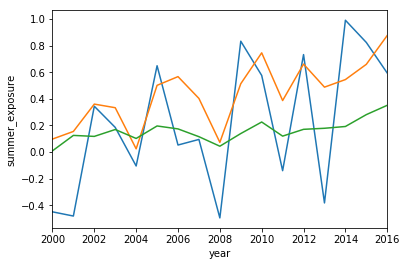

In [18]:
exposure_by_country['IN'].plot()
summer_exposures_ts.plot()
summer_anom_ts.plot()

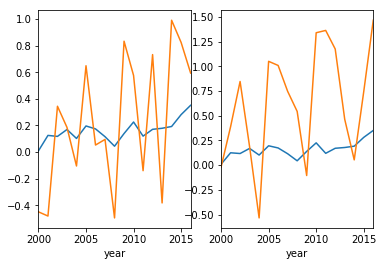

In [15]:
f, axs = plt.subplots(1, 2)

ax = axs[0]
summer_anom_ts.plot(ax=ax)
exposure_by_country['IN'].plot(ax=ax)

ax= axs[1]

summer_anom_ts.plot(ax=ax)
exposure_by_country['US'].plot(ax=ax)

### Do EU zones using EU NUTS file

In [17]:
eu_area_anom = rasterize_eu(eu_nuts, summer_anom)
eu_area_expo = rasterize_eu(eu_nuts, summer_exposures)


# eu_anom = summer_anom.where(eu_area_anom == 1)

In [38]:
country_da = eu_area_expo.copy()
country_num = 1
eu_exposures_ts = _project_to_population(summer_anom, country_da, country_num)
eu_exposures_ts.name = 'EU28'
eu_exposures_ts = eu_exposures_ts.to_dataframe()


In [39]:
eu_exposures_ts.to_csv('country_briefs/eu28_temperature_exposure.csv')

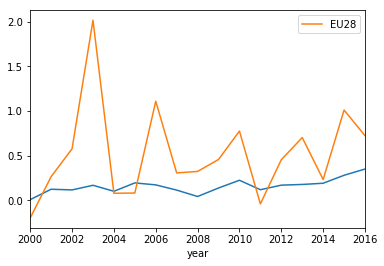

In [40]:
f, ax = plt.subplots()
summer_anom_ts.plot(ax=ax)
eu_exposures_ts.plot(ax=ax)